# Análisis de diversidad léxica de descriptores crossmodales

En este notebook se analiza los descriptores crossmodales asociados de alimentos, generados por un LLM, con respecto a la diversidad léxica de las los descriptores. También, se hace una comparativa entre la diversidad léxica de los descriptores generados por 2 diferentes plantillas de prompts.

> Este notebook fue desarrollado con asistencia de IA (Github Copilot) para que el código implementado se alineara un estilo de codificación acorde con proyectos de ML en python.  El alcance, metodología, definición de entradas y salidas, transformaciones de datos, revisión y análisis de los reslultados y revisión de código estuvieron a cargo del equipo de trabajo.  

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
# Importar el módulo de configuración
from config.config import load_config, setup_project_paths, PROJECT_ROOT
warnings.filterwarnings('ignore')

# Import wordcloud for text visualization
try:
    from wordcloud import WordCloud
    wordcloud_available = True
    print("✅ WordCloud disponible")
except ImportError:
    wordcloud_available = False
    print("⚠️  WordCloud no disponible. Instalar con: pip install wordcloud")

print("✅ Librerías importadas correctamente")

✅ WordCloud disponible
✅ Librerías importadas correctamente


In [2]:
# Configurar directorios del proyecto y cargar configuración
setup_project_paths()  # Crea todos los directorios necesarios
config = load_config()

# Configuración del archivo CSV
CSV_FILE_PATH = PROJECT_ROOT / config.data.cleaned_data_path / "food/prompt_experiment_results_20251123_102834.csv"  # Cambiar por tu archivo

In [3]:
def load_csv_data(file_path: str) -> pd.DataFrame:
    """
    Carga datos desde un archivo CSV
    
    El CSV debe contener al menos las siguientes columnas:
    - 'food_item': Elemento de comida analizado
    - 'template_name': Nombre de la plantilla usada
    - 'response': Respuesta con dimensiones separadas por '|'
    - 'success': Indicador booleano de respuesta exitosa
    
    Args:
        file_path: Ruta al archivo CSV
    
    Returns:
        DataFrame con los datos cargados
    """
    try:
        df = pd.read_csv(file_path)
        
        # Validar columnas requeridas
        required_columns = ['food_item', 'template_name', 'sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️  Columnas faltantes: {missing_columns}")
            print(f"Columnas disponibles: {list(df.columns)}")
            return pd.DataFrame()
        
        print(f"✅ Archivo cargado exitosamente!")
        print(f"Shape: {df.shape}")
        print(f"Respuestas exitosas: {df['success'].sum()}/{len(df)}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Archivo no encontrado: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error cargando archivo: {e}")
        return pd.DataFrame()

print("📁 Configuración del archivo:")
print(f"Ruta: {CSV_FILE_PATH}")

# Cargar datos
df = load_csv_data(CSV_FILE_PATH)
# Usar solo los primeros 10 registros para vista previa
results_df = df

📁 Configuración del archivo:
Ruta: /Users/jorge/workspace/personal/aws/maia/audio_reprompt/data/cleaned/food/prompt_experiment_results_20251123_102834.csv
✅ Archivo cargado exitosamente!
Shape: (600, 15)
Respuestas exitosas: 600/600


In [4]:
def prepare_data(dimensions_df: pd.DataFrame) -> Dict[str, List[str]]:
    """
    Prepara los datos para análisis ANOVA tokenizando términos por dimensión
    
    Args:
        dimensions_df: DataFrame con dimensiones separadas
    
    Returns:
        Diccionario con términos tokenizados por dimensión
    """
    if len(dimensions_df) == 0:
        return {}
    
    dimension_columns = ['sensations', 'human_responses', 'temperature', 
                        'texture', 'emotions', 'color', 'taste']
    
    anova_data = {}
    
    for dim in dimension_columns:
        if dim in dimensions_df.columns:
            # Extraer todos los términos de esta dimensión
            all_terms = []
            
            for response in dimensions_df[dim].dropna():
                # Separar por comas y limpiar
                terms = [term.strip().lower() for term in str(response).split(',')]
                # Filtrar términos vacíos
                terms = [term for term in terms if term and len(term) > 0]
                all_terms.extend(terms)
            
            anova_data[dim] = all_terms
    
    return anova_data

def analyze_term_frequencies(anova_data: Dict[str, List[str]]) -> Dict[str, Counter]:
    """
    Analiza las frecuencias de términos por dimensión
    
    Args:
        anova_data: Diccionario con términos por dimensión
    
    Returns:
        Diccionario con contadores de frecuencia por dimensión
    """
    frequency_analysis = {}
    
    for dimension, terms in anova_data.items():
        if len(terms) > 0:
            frequency_analysis[dimension] = Counter(terms)
    
    return frequency_analysis


In [5]:
def create_comparative_word_clouds(frequency_analysis: Dict[str, Counter], 
                                  top_n: int = 3) -> None:
    """
    Crea análisis comparativo de nubes de palabras mostrando las dimensiones 
    con mayor diversidad léxica
    
    Args:
        frequency_analysis: Diccionario con contadores de frecuencia por dimensión
        top_n: Número de dimensiones top a mostrar en detalle
    """
    if not wordcloud_available:
        print("⚠️  WordCloud no está disponible para análisis comparativo")
        return
        
    if not frequency_analysis:
        print("⚠️  No hay datos para análisis comparativo")
        return
    
    # Calcular métricas de diversidad por dimensión
    diversity_metrics = {}
    for dimension, counter in frequency_analysis.items():
        total_terms = sum(counter.values())
        unique_terms = len(counter)
        
        # Métricas de diversidad
        diversity_metrics[dimension] = {
            'total_terms': total_terms,
            'unique_terms': unique_terms,
            'diversity_ratio': unique_terms / total_terms if total_terms > 0 else 0,
            'entropy': -sum((freq/total_terms) * np.log2(freq/total_terms) 
                           for freq in counter.values()) if total_terms > 0 else 0,
            'max_frequency': max(counter.values()) if counter else 0,
            'counter': counter
        }
    
    # Ordenar por diversidad (ratio de términos únicos)
    sorted_dimensions = sorted(diversity_metrics.items(), 
                             key=lambda x: x[1]['diversity_ratio'], reverse=True)
    """
    print(f"📊 ANÁLISIS DE DIVERSIDAD LÉXICA")
    print("="*50)
    
    for i, (dimension, metrics) in enumerate(sorted_dimensions, 1):
        print(f"{i}. {dimension.upper()}:")
        print(f"   - Términos únicos: {metrics['unique_terms']}")
        print(f"   - Total términos: {metrics['total_terms']}")
        print(f"   - Ratio diversidad: {metrics['diversity_ratio']:.3f}")
        print(f"   - Entropía: {metrics['entropy']:.3f}")
        print()
    """
    # Mostrar nubes de palabras para las top N dimensiones más diversas
    if len(sorted_dimensions) > 0:
        top_dimensions = sorted_dimensions[:min(top_n, len(sorted_dimensions))]
        
        fig, axes = plt.subplots(1, len(top_dimensions), 
                                figsize=(6 * len(top_dimensions), 6))
        
        if len(top_dimensions) == 1:
            axes = [axes]
        
        fig.suptitle(f'Top {len(top_dimensions)} Dimensiones Más Diversas', 
                    fontsize=16, fontweight='bold')
        
        # Definir colores diferentes para cada dimensión
        color_schemes = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
        
        for i, (dimension, metrics) in enumerate(top_dimensions):
            counter = metrics['counter']
            
            if len(counter) > 0:
                # Configurar WordCloud con esquema de color único
                wordcloud_params = {
                    'width': 400,
                    'height': 400,
                    'background_color': 'white',
                    'max_words': 30,
                    'colormap': color_schemes[i % len(color_schemes)],
                    'relative_scaling': 0.6,
                    'min_font_size': 8,
                    'prefer_horizontal': 0.7
                }
                
                try:
                    wordcloud = WordCloud(**wordcloud_params).generate_from_frequencies(
                        dict(counter))
                    
                    axes[i].imshow(wordcloud, interpolation='bilinear')
                    axes[i].set_title(
                        f'{dimension.title()}\nDiversidad: {metrics["diversity_ratio"]:.3f}\n'
                        f'Entropía: {metrics["entropy"]:.2f}',
                        fontsize=12, fontweight='bold'
                    )
                    axes[i].axis('off')
                    
                except Exception as e:
                    axes[i].text(0.5, 0.5, f'Error\n{dimension}', 
                               ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].set_title(dimension.title())
                    axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, 'Sin datos', ha='center', va='center',
                           transform=axes[i].transAxes)
                axes[i].set_title(dimension.title())
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Análisis de términos únicos vs comunes
        print(f"\n🔍 ANÁLISIS DE TÉRMINOS ÚNICOS:")
        
        # Encontrar términos que aparecen en múltiples dimensiones
        all_terms = set()
        for counter in frequency_analysis.values():
            all_terms.update(counter.keys())
        
        # Contar en cuántas dimensiones aparece cada término
        term_dimension_count = Counter()
        for term in all_terms:
            count = sum(1 for counter in frequency_analysis.values() if term in counter)
            term_dimension_count[term] = count
        
        # Términos exclusivos (solo en una dimensión)
        exclusive_terms = [term for term, count in term_dimension_count.items() if count == 1]
        shared_terms = [term for term, count in term_dimension_count.items() if count > 1]
        
        print(f"   - Términos exclusivos: {len(exclusive_terms)}")
        print(f"   - Términos compartidos: {len(shared_terms)}")
        
        if shared_terms:
            most_shared = max(term_dimension_count.items(), key=lambda x: x[1])
            print(f"   - Término más compartido: '{most_shared[0]}' ({most_shared[1]} dimensiones)")

In [6]:
def create_text_frequency_visualizations(frequency_analysis: Dict[str, Counter], 
                                        top_terms: int = 10) -> None:
    """
    Crea visualizaciones alternativas de frecuencia de términos usando barras horizontales
    cuando WordCloud no está disponible
    
    Args:
        frequency_analysis: Diccionario con contadores de frecuencia por dimensión
        top_terms: Número de términos top a mostrar por dimensión
    """
    if not frequency_analysis:
        print("⚠️  No hay datos de frecuencia para visualizar")
        return
    
    dimensions = list(frequency_analysis.keys())
    n_dims = len(dimensions)
    
    if n_dims == 0:
        print("⚠️  No hay dimensiones para visualizar")
        return
    
    # Configurar subplots
    cols = 2
    rows = (n_dims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    fig.suptitle('Frecuencia de Términos por Dimensión (Top 10)', 
                fontsize=16, fontweight='bold')
    
    # Manejar el caso de un solo subplot
    if n_dims == 1:
        axes = [axes] if rows * cols == 1 else [axes[0]]
    elif rows == 1:
        axes = [axes] if n_dims == 1 else axes
    else:
        axes = axes.flatten()
    
    # Paleta de colores
    colors = plt.cm.Set3(np.linspace(0, 1, n_dims))
    
    for i, (dimension, counter) in enumerate(frequency_analysis.items()):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        if len(counter) > 0:
            # Obtener top términos
            top_items = counter.most_common(top_terms)
            terms, frequencies = zip(*top_items) if top_items else ([], [])
            
            # Crear barras horizontales
            y_pos = np.arange(len(terms))
            bars = ax.barh(y_pos, frequencies, color=colors[i], alpha=0.7)
            
            # Configurar ejes
            ax.set_yticks(y_pos)
            ax.set_yticklabels(terms)
            ax.invert_yaxis()  # Términos con mayor frecuencia arriba
            ax.set_xlabel('Frecuencia')
            ax.set_title(f'{dimension.title()}\n({len(counter)} términos únicos)', 
                        fontsize=12, fontweight='bold')
            
            # Añadir valores en las barras
            for j, (bar, freq) in enumerate(zip(bars, frequencies)):
                width = bar.get_width()
                ax.text(width + max(frequencies) * 0.01, bar.get_y() + bar.get_height()/2,
                       f'{freq}', ha='left', va='center', fontweight='bold')
            
            # Grid para facilitar lectura
            ax.grid(axis='x', alpha=0.3)
            
        else:
            ax.text(0.5, 0.5, f'Sin datos para\n{dimension}', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=14)
            ax.set_title(dimension.title(), fontsize=12)
        
        # Remover spines innecesarios
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Ocultar subplots vacíos
    for i in range(n_dims, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Crear gráfico de barras comparativo por diversidad
    print("\n📊 Creando gráfico de diversidad léxica...")
    
    # Calcular métricas de diversidad
    diversity_data = []
    for dimension, counter in frequency_analysis.items():
        total_terms = sum(counter.values())
        unique_terms = len(counter)
        diversity_ratio = unique_terms / total_terms if total_terms > 0 else 0
        
        diversity_data.append({
            'dimension': dimension,
            'unique_terms': unique_terms,
            'total_terms': total_terms,
            'diversity_ratio': diversity_ratio
        })
    
    # Ordenar por ratio de diversidad
    diversity_data.sort(key=lambda x: x['diversity_ratio'], reverse=True)
    
    # Crear gráfico de diversidad
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Análisis de Diversidad Léxica por Dimensión', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Términos únicos vs totales
    dimensions_names = [d['dimension'] for d in diversity_data]
    unique_counts = [d['unique_terms'] for d in diversity_data]
    total_counts = [d['total_terms'] for d in diversity_data]
    
    x = np.arange(len(dimensions_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, unique_counts, width, label='Términos únicos', alpha=0.8)
    bars2 = ax1.bar(x + width/2, total_counts, width, label='Total términos', alpha=0.8)
    
    ax1.set_xlabel('Dimensiones')
    ax1.set_ylabel('Número de términos')
    ax1.set_title('Términos Únicos vs Total por Dimensión')
    ax1.set_xticks(x)
    ax1.set_xticklabels([d.title() for d in dimensions_names], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
    
    # Gráfico 2: Ratio de diversidad
    diversity_ratios = [d['diversity_ratio'] for d in diversity_data]
    bars3 = ax2.bar(dimensions_names, diversity_ratios, 
                    color=plt.cm.viridis(np.linspace(0, 1, len(dimensions_names))), 
                    alpha=0.8)
    
    ax2.set_xlabel('Dimensiones')
    ax2.set_ylabel('Ratio de Diversidad')
    ax2.set_title('Ratio de Diversidad Léxica\n(Términos únicos / Total términos)')
    ax2.set_xticklabels(dimensions_names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bar, ratio in zip(bars3, diversity_ratios):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Resumen textual
    print(f"\n📈 RESUMEN DE VISUALIZACIONES:")
    print(f"   - Dimensiones analizadas: {n_dims}")
    print(f"   - Terms por dimensión (top {top_terms} mostrados)")
    
    most_diverse = max(diversity_data, key=lambda x: x['diversity_ratio'])
    least_diverse = min(diversity_data, key=lambda x: x['diversity_ratio'])
    
    print(f"   - Más diversa: {most_diverse['dimension']} ({most_diverse['diversity_ratio']:.3f})")
    print(f"   - Menos diversa: {least_diverse['dimension']} ({least_diverse['diversity_ratio']:.3f})")

# Ejecutar visualizaciones alternativas (siempre disponibles)
if 'frequency_analysis' in locals() and frequency_analysis:
    print("📊 Creando visualizaciones de frecuencia de términos...")
    create_text_frequency_visualizations(frequency_analysis, top_terms=10)
else:
    print("⚠️  No hay análisis de frecuencias para las visualizaciones")

⚠️  No hay análisis de frecuencias para las visualizaciones


📊 Plantillas encontradas: ['sensations_emotions_mapping_no_bias'
 'sensations_emotions_mapping_with_acceptance_criteria']
🔄 Preparando datos para análisis ANOVA...
✅ Datos preparados!
Dimensiones encontradas: ['sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']

📊 Estadísticas por dimensión:
  sensations:
    - Total términos: 904
    - Términos únicos: 62
    - Diversidad: 0.07
    - Top 3 términos: [('savory', 115), ('umami', 84), ('creamy', 81)]

  human_responses:
    - Total términos: 897
    - Términos únicos: 75
    - Diversidad: 0.08
    - Top 3 términos: [('satisfaction', 199), ('warmth', 144), ('fullness', 79)]

  temperature:
    - Total términos: 299
    - Términos únicos: 5
    - Diversidad: 0.02
    - Top 3 términos: [('warm', 157), ('hot', 73), ('cold', 55)]

  texture:
    - Total términos: 897
    - Términos únicos: 54
    - Diversidad: 0.06
    - Top 3 términos: [('smooth', 142), ('creamy', 98), ('soft', 78)]

  emotions:
    - Tot

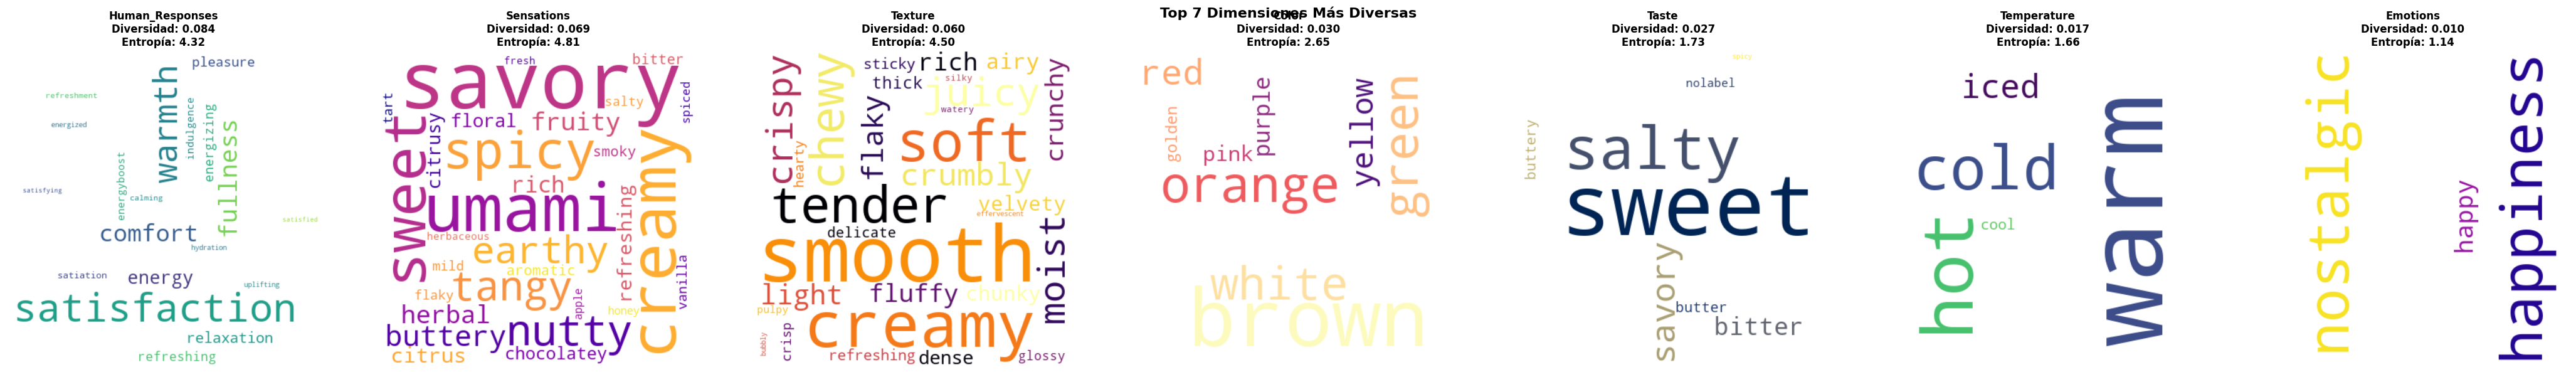


🔍 ANÁLISIS DE TÉRMINOS ÚNICOS:
   - Términos exclusivos: 172
   - Términos compartidos: 20
   - Término más compartido: 'happiness' (3 dimensiones)


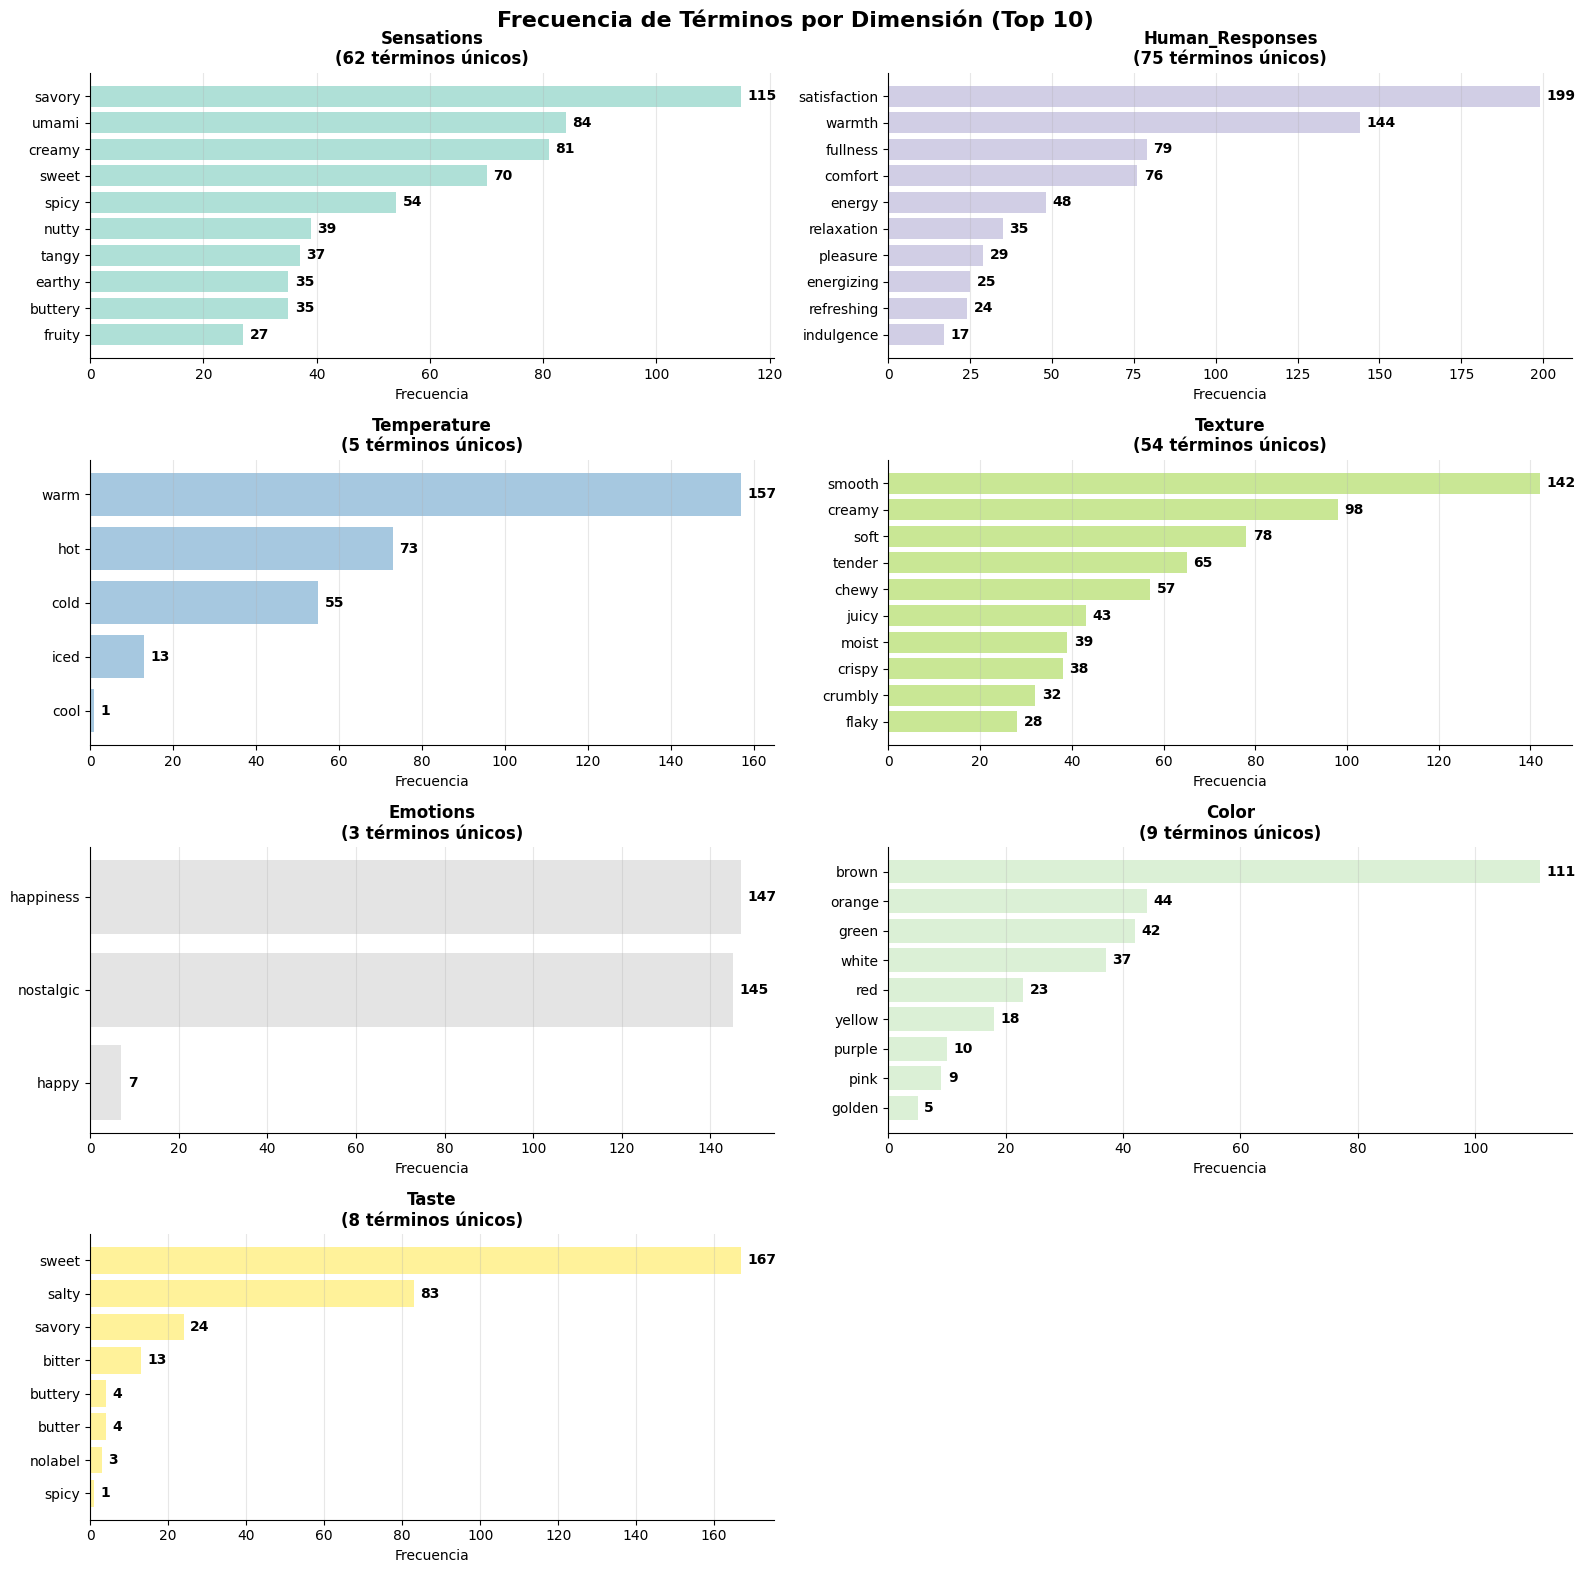


📊 Creando gráfico de diversidad léxica...


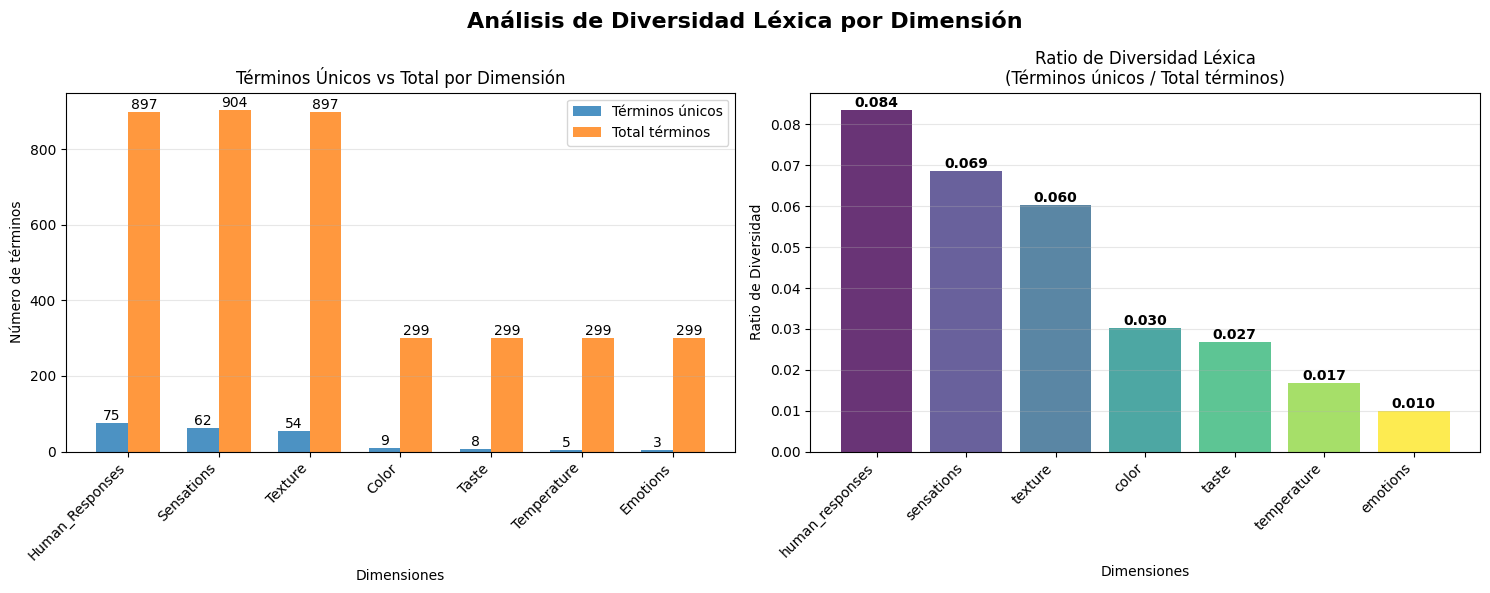


📈 RESUMEN DE VISUALIZACIONES:
   - Dimensiones analizadas: 7
   - Terms por dimensión (top 10 mostrados)
   - Más diversa: human_responses (0.084)
   - Menos diversa: emotions (0.010)


In [7]:

# Preparar datos para análisis de frecuencia de términoss
# Separar results_df en dos data frames basados en la columna template_name
template_names = results_df['template_name'].unique()
print(f"📊 Plantillas encontradas: {template_names}")
template_bias_df = results_df[results_df['template_name'] == template_names[0]]
template_bias_ac = results_df[results_df['template_name'] == template_names[1]]


if 'template_bias_df' in locals() and len(template_bias_df) > 0:
    print("🔄 Preparando datos para análisis ANOVA...")
    anova_data = prepare_data(template_bias_df)
    frequency_analysis = analyze_term_frequencies(anova_data)
    
    print("✅ Datos preparados!")
    print(f"Dimensiones encontradas: {list(anova_data.keys())}")
    
    # Mostrar estadísticas básicas por dimensión
    print(f"\n📊 Estadísticas por dimensión:")
    for dim, terms in anova_data.items():
        unique_terms = len(set(terms))
        total_terms = len(terms)
        print(f"  {dim}:")
        print(f"    - Total términos: {total_terms}")
        print(f"    - Términos únicos: {unique_terms}")
        print(f"    - Diversidad: {unique_terms/total_terms:.2f}")
        
        # Mostrar los 3 términos más frecuentes
        if dim in frequency_analysis and len(frequency_analysis[dim]) > 0:
            top_terms = frequency_analysis[dim].most_common(3)
            print(f"    - Top 3 términos: {top_terms}")
        print()

    create_comparative_word_clouds(frequency_analysis, top_n=7)
    create_text_frequency_visualizations(frequency_analysis, top_terms=10)
else:
    print("⚠️  No hay datos para preparar el análisis ANOVA")

🔄 Preparando datos para análisis ANOVA...
✅ Datos preparados!
Dimensiones encontradas: ['sensations', 'human_responses', 'temperature', 'texture', 'emotions', 'color', 'taste']

📊 Estadísticas por dimensión:
  sensations:
    - Total términos: 889
    - Términos únicos: 73
    - Diversidad: 0.08
    - Top 3 términos: [('savory', 110), ('umami', 83), ('creamy', 75)]

  human_responses:
    - Total términos: 865
    - Términos únicos: 83
    - Diversidad: 0.10
    - Top 3 términos: [('satisfaction', 200), ('warmth', 124), ('comfort', 68)]

  temperature:
    - Total términos: 295
    - Términos únicos: 5
    - Diversidad: 0.02
    - Top 3 términos: [('warm', 158), ('hot', 64), ('cold', 54)]

  texture:
    - Total términos: 871
    - Términos únicos: 54
    - Diversidad: 0.06
    - Top 3 términos: [('smooth', 121), ('creamy', 90), ('tender', 71)]

  emotions:
    - Total términos: 295
    - Términos únicos: 2
    - Diversidad: 0.01
    - Top 3 términos: [('happiness', 288), ('nolabel', 7

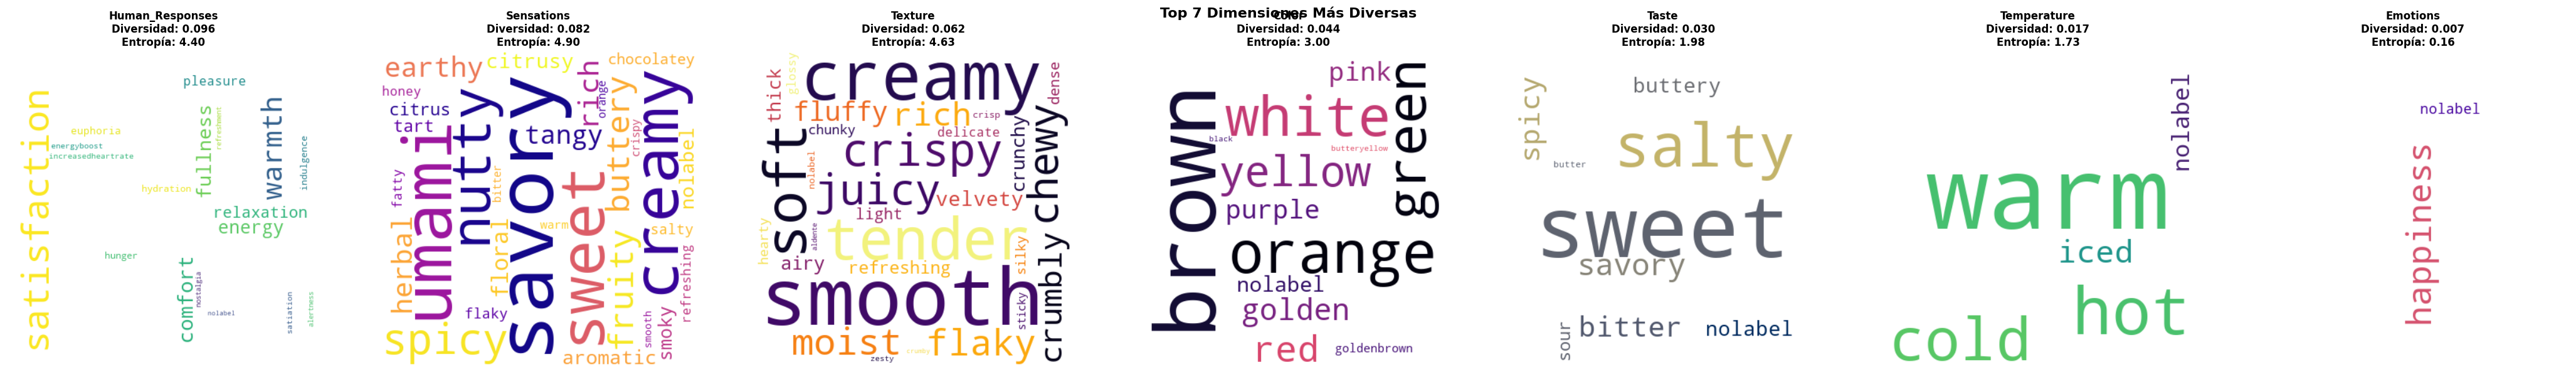


🔍 ANÁLISIS DE TÉRMINOS ÚNICOS:
   - Términos exclusivos: 180
   - Términos compartidos: 25
   - Término más compartido: 'nolabel' (7 dimensiones)


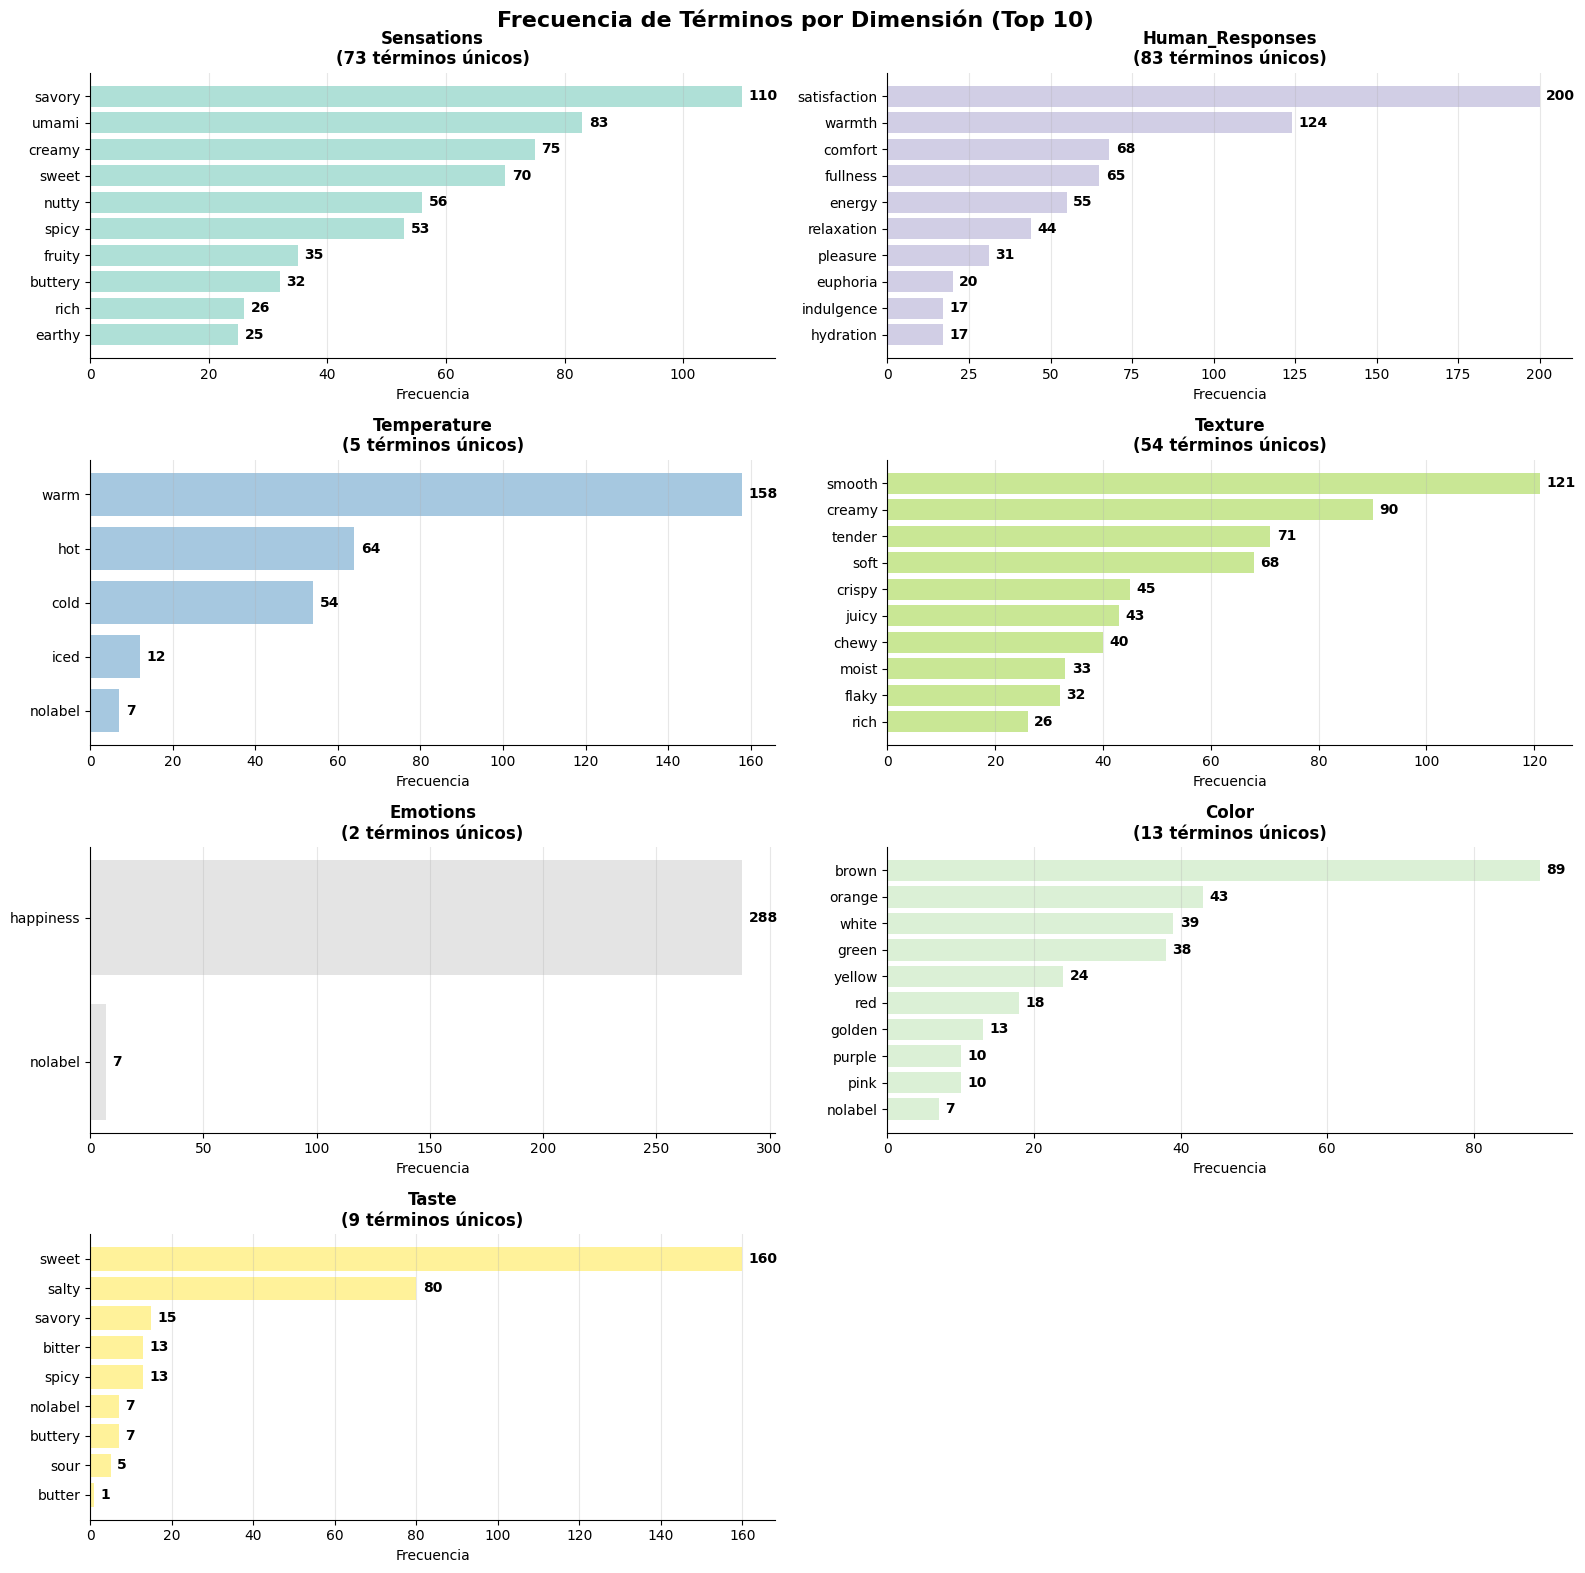


📊 Creando gráfico de diversidad léxica...


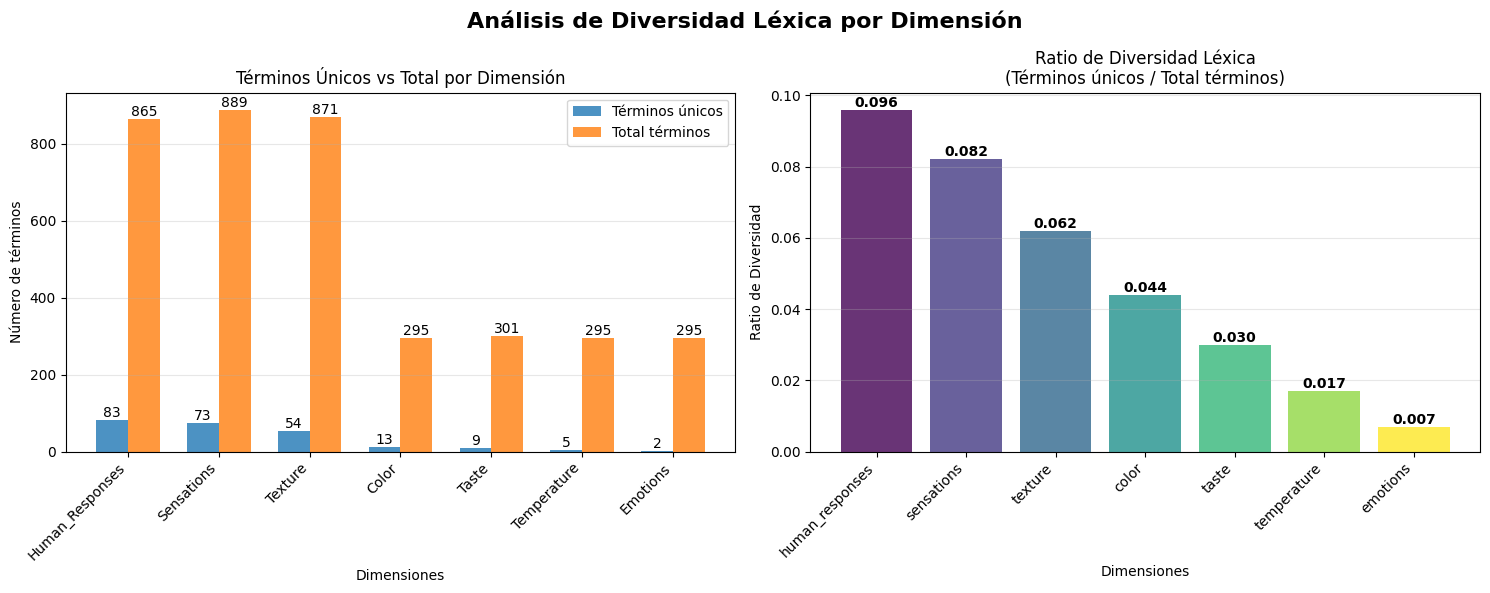


📈 RESUMEN DE VISUALIZACIONES:
   - Dimensiones analizadas: 7
   - Terms por dimensión (top 10 mostrados)
   - Más diversa: human_responses (0.096)
   - Menos diversa: emotions (0.007)


In [8]:
if 'template_bias_ac' in locals() and len(template_bias_ac) > 0:
    print("🔄 Preparando datos para análisis ANOVA...")
    anova_data = prepare_data(template_bias_ac)
    frequency_analysis = analyze_term_frequencies(anova_data)
    
    print("✅ Datos preparados!")
    print(f"Dimensiones encontradas: {list(anova_data.keys())}")
    
    # Mostrar estadísticas básicas por dimensión
    print(f"\n📊 Estadísticas por dimensión:")
    for dim, terms in anova_data.items():
        unique_terms = len(set(terms))
        total_terms = len(terms)
        print(f"  {dim}:")
        print(f"    - Total términos: {total_terms}")
        print(f"    - Términos únicos: {unique_terms}")
        print(f"    - Diversidad: {unique_terms/total_terms:.2f}")
        
        # Mostrar los 3 términos más frecuentes
        if dim in frequency_analysis and len(frequency_analysis[dim]) > 0:
            top_terms = frequency_analysis[dim].most_common(3)
            print(f"    - Top 3 términos: {top_terms}")
        print()

    create_comparative_word_clouds(frequency_analysis, top_n=7)
    create_text_frequency_visualizations(frequency_analysis, top_terms=10)
else:
    print("⚠️  No hay datos para preparar el análisis ANOVA")

# Estadísticas Descriptivas de Diversidad Léxica

En esta sección calculamos estadísticas descriptivas sobre la diversidad léxica de los términos generados, agrupando por `template_name` y `food_item`.

In [9]:
def calculate_lexical_statistics(row: pd.Series) -> Dict[str, Any]:
    """
    Calcula estadísticas de diversidad léxica para una fila del DataFrame
    
    Args:
        row: Fila del DataFrame con columnas de dimensiones
    
    Returns:
        Diccionario con estadísticas: unique_terms, total_terms, diversity_ratio
    """
    dimension_columns = ['sensations', 'human_responses', 'temperature', 
                        'texture', 'emotions', 'color', 'taste']
    
    all_terms = []
    for dim in dimension_columns:
        if pd.notna(row[dim]):
            terms = [t.strip().lower() for t in str(row[dim]).split(',') if t.strip()]
            all_terms.extend(terms)
    
    unique_terms = len(set(all_terms))
    total_terms = len(all_terms)
    diversity_ratio = unique_terms / total_terms if total_terms > 0 else 0
    
    return {
        'unique_terms': unique_terms,
        'total_terms': total_terms,
        'diversity_ratio': diversity_ratio
    }

# Calcular estadísticas para cada fila
lexical_stats = results_df.apply(calculate_lexical_statistics, axis=1, result_type='expand')
results_with_stats = pd.concat([results_df, lexical_stats], axis=1)

print("✅ Estadísticas léxicas calculadas")
print(f"Shape del DataFrame resultante: {results_with_stats.shape}")
results_with_stats[['food_item', 'template_name', 'unique_terms', 'total_terms', 'diversity_ratio']].head()

✅ Estadísticas léxicas calculadas
Shape del DataFrame resultante: (600, 18)


,food_item,template_name,unique_terms,total_terms,diversity_ratio
0,Chocolate,sensations_emotions_mapping_no_bias,13.0,13.0,1.000000
1,Chocolate,sensations_emotions_mapping_no_bias,13.0,13.0,1.000000
2,Chocolate,sensations_emotions_mapping_no_bias,13.0,13.0,1.000000
3,Chocolate,sensations_emotions_mapping_no_bias,12.0,13.0,0.923077
4,Chocolate,sensations_emotions_mapping_no_bias,12.0,13.0,0.923077


## Estadísticas Agrupadas por Template

In [10]:
# Estadísticas agrupadas por template_name
stats_by_template = results_with_stats.groupby('template_name')[
    ['unique_terms', 'total_terms', 'diversity_ratio']
].agg(['mean', 'var', 'min', 'max'])

print("📊 Estadísticas por Template:")
print("="*80)
stats_by_template

📊 Estadísticas por Template:


unique_terms            \
                                                           mean       var   
template_name                                                               
sensations_emotions_mapping_no_bias                   12.413333  0.504169   
sensations_emotions_mapping_with_acceptance_cri...    11.963333  4.463534   

                                                              total_terms  \
                                                    min   max        mean   
template_name                                                               
sensations_emotions_mapping_no_bias                 6.0  13.0   12.980000   
sensations_emotions_mapping_with_acceptance_cri...  1.0  14.0   12.703333   

                                                                        \
                                                        var  min   max   
template_name                                                            
sensations_emotions_mapping_no_bias                 0.12000  7.0  13.0   
sensations_emotions_mapping_with_acceptance_cri...  1.78126  5.0  14.0   

                                                   diversity_ratio            \
                                                              mean       var   
template_name                                                                  
sensations_emotions_mapping_no_bias                       0.956190  0.002199   
sensations_emotions_mapping_with_acceptance_cri...        0.931808  0.019213   

                                                                   
                                                         min  max  
template_name                                                      
sensations_emotions_mapping_no_bias                 0.846154  1.0  
sensations_emotions_mapping_with_acceptance_cri...  0.142857  1.0

## Estadísticas Agrupadas por Food Item

In [11]:
# Estadísticas agrupadas por food_item
stats_by_food = results_with_stats.groupby('food_item')[
    ['unique_terms', 'total_terms', 'diversity_ratio']
].agg(['mean', 'var', 'min', 'max'])

print("📊 Estadísticas por Food Item (Top 10 por diversidad media):")
print("="*80)
# Ordenar por diversidad media y mostrar top 10
stats_by_food_sorted = stats_by_food.sort_values(
    by=('diversity_ratio', 'mean'), 
    ascending=False
)
stats_by_food_sorted.head(10)

📊 Estadísticas por Food Item (Top 10 por diversidad media):


unique_terms                       total_terms            \
                           mean       var   min   max        mean       var   
food_item                                                                     
salmon cooked             13.00  0.000000  13.0  13.0        13.0  0.000000   
thai spring rolls         13.05  0.155263  12.0  14.0        13.1  0.094737   
brazilian feijoada        12.90  0.094737  12.0  13.0        13.0  0.000000   
poached egg               12.85  0.134211  12.0  13.0        13.0  0.000000   
Orange Juice              12.85  0.134211  12.0  13.0        13.0  0.000000   
coffee                    12.85  0.134211  12.0  13.0        13.0  0.000000   
chocolate cookies         12.50  0.578947  11.0  13.0        12.7  0.536842   
honey apple cake          12.70  0.221053  12.0  13.0        13.0  0.000000   
tacos                     12.70  0.221053  12.0  13.0        13.0  0.000000   
Chocolate                 12.55  0.365789  11.0  13.0        12.9  0.200000   

                               diversity_ratio                           
                     min   max            mean       var       min  max  
food_item                                                                
salmon cooked       13.0  13.0        1.000000  0.000000  1.000000  1.0  
thai spring rolls   13.0  14.0        0.996154  0.000296  0.923077  1.0  
brazilian feijoada  13.0  13.0        0.992308  0.000561  0.923077  1.0  
poached egg         13.0  13.0        0.988462  0.000794  0.923077  1.0  
Orange Juice        13.0  13.0        0.988462  0.000794  0.923077  1.0  
coffee              13.0  13.0        0.988462  0.000794  0.923077  1.0  
chocolate cookies   11.0  13.0        0.984615  0.000997  0.923077  1.0  
honey apple cake    13.0  13.0        0.976923  0.001308  0.923077  1.0  
tacos               13.0  13.0        0.976923  0.001308  0.923077  1.0  
Chocolate           11.0  13.0        0.973077  0.001417  0.923077  1.0

## Estadísticas agrupadas por tempalte y food item

In [17]:
# Estadísticas agrupadas por template_name
stats_by_template = results_with_stats.groupby(['template_name', 'food_item'])[
    #['unique_terms', 'total_terms', 'diversity_ratio']
    ['diversity_ratio']
].agg(['mean', 'var', 'min', 'max'])

print("📊 Estadísticas por Template y food item:")
print("="*80)
stats_by_template

📊 Estadísticas por Template y food item:


diversity_ratio  \
                                                                                  mean   
template_name                                      food_item                             
sensations_emotions_mapping_no_bias                Chocolate                  0.961538   
                                                   Orange Juice               0.984615   
                                                   Popcorn                    0.961538   
                                                   Yogurt                     0.923077   
                                                   aperol                     0.969231   
                                                   brazilian caipiriña        0.915385   
                                                   brazilian feijoada         1.000000   
                                                   chocolate cookies          0.984615   
                                                   coffee                     0.992308   
                                                   creamy peas                0.930769   
                                                   croissant                  0.976923   
                                                   curry chicken              0.946154   
                                                   fish and chips             0.961538   
                                                   honey apple cake           0.992308   
                                                   lavender sorbet            0.992308   
                                                   mascarpone tiramisu        0.869231   
                                                   meatballs                  0.930769   
                                                   pasta carbonara            0.923077   
                                                   pistachio cake             0.930769   
                                                   poached egg                1.000000   
                                                   pumpkin cookies            0.901099   
                                                   ranch noodles              0.946154   
                                                   ricotta roll               0.969231   
                                                   salmon cooked              1.000000   
                                                   shrimp creole              0.969231   
                                                   strawberry                 0.946154   
                                                   sweet potato pone          0.915385   
                                                   tacos                      0.969231   
                                                   teriyaki marinade          0.923077   
                                                   thai spring rolls          1.000000   
sensations_emotions_mapping_with_acceptance_cri... Chocolate                  0.984615   
                                                   Orange Juice               0.992308   
                                                   Popcorn                    0.946154   
                                                   Yogurt                     0.923077   
                                                   aperol                     0.802814   
                                                   brazilian caipiriña        0.947253   
                                                   brazilian feijoada         0.984615   
                                                   chocolate cookies          0.984615   
                                                   coffee                     0.984615   
                                                   creamy peas                0.976923   
                                                   croissant                  0.946154   
                                                   curry chicken              0.938462   
                     

## Estadísticas Globales (Sin Agrupación)

In [12]:
# Estadísticas globales (sin agrupación)
global_stats = results_with_stats[['unique_terms', 'total_terms', 'diversity_ratio']].agg(
    ['mean', 'var', 'min', 'max']
)

print("🌍 Estadísticas Globales:")
print("="*80)
global_stats

🌍 Estadísticas Globales:


,unique_terms,total_terms,diversity_ratio
mean,12.188333,12.841667,0.943999
var,2.530415,0.968211,0.010837
min,1.000000,5.000000,0.142857
max,14.000000,14.000000,1.000000


## Tabla Comparativa Consolidada

Comparación lado a lado de las estadísticas agrupadas y globales.

In [13]:
# Crear tabla comparativa consolidada
print("📋 TABLA COMPARATIVA CONSOLIDADA")
print("="*100)
print("\n1️⃣  ESTADÍSTICAS POR TEMPLATE:")
print("-"*100)
display(stats_by_template.round(4))

print("\n2️⃣  ESTADÍSTICAS POR FOOD ITEM (Completo):")
print("-"*100)
display(stats_by_food_sorted.round(4))

print("\n3️⃣  ESTADÍSTICAS GLOBALES:")
print("-"*100)
display(global_stats.round(4))

# Crear tabla resumida comparativa
print("\n📊 RESUMEN COMPARATIVO (Media de Diversidad):")
print("="*100)

comparison_summary = pd.DataFrame({
    'Agrupación': ['Global', *stats_by_template.index],
    'Diversidad Media': [
        global_stats.loc['mean', 'diversity_ratio'],
        *stats_by_template[('diversity_ratio', 'mean')].values
    ],
    'Términos Únicos Media': [
        global_stats.loc['mean', 'unique_terms'],
        *stats_by_template[('unique_terms', 'mean')].values
    ],
    'Total Términos Media': [
        global_stats.loc['mean', 'total_terms'],
        *stats_by_template[('total_terms', 'mean')].values
    ]
})

display(comparison_summary.round(4))

# Estilizar tabla con gradientes de color
comparison_styled = comparison_summary.style.background_gradient(
    subset=['Diversidad Media', 'Términos Únicos Media', 'Total Términos Media'],
    cmap='RdYlGn'
)
display(comparison_styled)

📋 TABLA COMPARATIVA CONSOLIDADA

1️⃣  ESTADÍSTICAS POR TEMPLATE:
----------------------------------------------------------------------------------------------------


unique_terms               \
                                                           mean     var  min   
template_name                                                                  
sensations_emotions_mapping_no_bias                     12.4133  0.5042  6.0   
sensations_emotions_mapping_with_acceptance_cri...      11.9633  4.4635  1.0   

                                                         total_terms          \
                                                     max        mean     var   
template_name                                                                  
sensations_emotions_mapping_no_bias                 13.0     12.9800  0.1200   
sensations_emotions_mapping_with_acceptance_cri...  14.0     12.7033  1.7813   

                                                              diversity_ratio  \
                                                    min   max            mean   
template_name                                                                   
sensations_emotions_mapping_no_bias                 7.0  13.0          0.9562   
sensations_emotions_mapping_with_acceptance_cri...  5.0  14.0          0.9318   

                                                                         
                                                       var     min  max  
template_name                                                            
sensations_emotions_mapping_no_bias                 0.0022  0.8462  1.0  
sensations_emotions_mapping_with_acceptance_cri...  0.0192  0.1429  1.0


2️⃣  ESTADÍSTICAS POR FOOD ITEM (Completo):
----------------------------------------------------------------------------------------------------


unique_terms                      total_terms          \
                            mean      var   min   max        mean     var   
food_item                                                                   
salmon cooked              13.00   0.0000  13.0  13.0       13.00  0.0000   
thai spring rolls          13.05   0.1553  12.0  14.0       13.10  0.0947   
brazilian feijoada         12.90   0.0947  12.0  13.0       13.00  0.0000   
poached egg                12.85   0.1342  12.0  13.0       13.00  0.0000   
Orange Juice               12.85   0.1342  12.0  13.0       13.00  0.0000   
coffee                     12.85   0.1342  12.0  13.0       13.00  0.0000   
chocolate cookies          12.50   0.5789  11.0  13.0       12.70  0.5368   
honey apple cake           12.70   0.2211  12.0  13.0       13.00  0.0000   
tacos                      12.70   0.2211  12.0  13.0       13.00  0.0000   
Chocolate                  12.55   0.3658  11.0  13.0       12.90  0.2000   
lavender sorbet            12.55   0.3658  11.0  13.0       13.00  0.0000   
croissant                  12.50   0.2632  12.0  13.0       13.00  0.0000   
strawberry                 12.50   0.2632  12.0  13.0       13.00  0.0000   
shrimp creole              12.45   0.2605  12.0  13.0       13.00  0.0000   
fish and chips             12.40   0.2526  12.0  13.0       13.00  0.0000   
creamy peas                12.40   0.3579  11.0  13.0       13.00  0.0000   
Popcorn                    12.40   0.3579  11.0  13.0       13.00  0.0000   
ricotta roll               12.35   0.4500  11.0  13.0       13.00  0.0000   
curry chicken              12.25   0.1974  12.0  13.0       13.00  0.0000   
meatballs                  12.15   0.2395  11.0  13.0       13.00  0.0000   
brazilian caipiriña        12.15   0.4500  11.0  13.0       13.05  0.0500   
pistachio cake             12.10   0.0947  12.0  13.0       13.00  0.0000   
teriyaki marinade          12.00   0.1053  11.0  13.0       13.00  0.0000   
Yogurt                     12.00   0.0000  12.0  12.0       13.00  0.0000   
sweet potato pone          11.95   0.0500  11.0  12.0       13.00  0.0000   
pasta carbonara            11.90   0.0947  11.0  12.0       13.00  0.0000   
pumpkin cookies            10.85   5.3974   4.0  12.0       12.00  6.1053   
aperol                     10.80  17.7474   1.0  14.0       11.70  8.3263   
mascarpone tiramisu        11.40   0.4632  11.0  13.0       13.00  0.0000   
ranch noodles               8.60  27.2000   1.0  13.0       10.80  7.9579   

                                diversity_ratio                          
                      min   max            mean     var     min     max  
food_item                                                                
salmon cooked        13.0  13.0          1.0000  0.0000  1.0000  1.0000  
thai spring rolls    13.0  14.0          0.9962  0.0003  0.9231  1.0000  
brazilian feijoada   13.0  13.0          0.9923  0.0006  0.9231  1.0000  
poached egg          13.0  13.0          0.9885  0.0008  0.9231  1.0000  
Orange Juice         13.0  13.0          0.9885  0.0008  0.9231  1.0000  
coffee               13.0  13.0          0.9885  0.0008  0.9231  1.0000  
chocolate cookies    11.0  13.0          0.9846  0.0010  0.9231  1.0000  
honey apple cake     13.0  13.0          0.9769  0.0013  0.9231  1.0000  
tacos                13.0  13.0          0.9769  0.0013  0.9231  1.0000  
Chocolate            11.0  13.0          0.9731  0.0014  0.9231  1.0000  
lavender sorbet      13.0  13.0          0.9654  0.0022  0.8462  1.0000  
croissant            13.0  13.0          0.9615  0.0016  0.9231  1.0000  
strawberry           13.0  13.0          0.9615  0.0016  0.9231  1.0000  
shrimp creole        13.0  13.0          0.9577  0.0015  0.9231  1.0000  
fish and chips       13.0  13.0          0.9538  0.0015  0.9231  1.0000  
creamy peas          13.0  13.0          0.9538  0.0021  0.8462  1.0000  
Popcorn              13.0  13.0          0.9538  0.0021  0.8462  1.0000 


3️⃣  ESTADÍSTICAS GLOBALES:
----------------------------------------------------------------------------------------------------


,unique_terms,total_terms,diversity_ratio
mean,12.1883,12.8417,0.9440
var,2.5304,0.9682,0.0108
min,1.0000,5.0000,0.1429
max,14.0000,14.0000,1.0000



📊 RESUMEN COMPARATIVO (Media de Diversidad):


,Agrupación,Diversidad Media,Términos Únicos Media,Total Términos Media
0,Global,0.9440,12.1883,12.8417
1,sensations_emotions_mapping_no_bias,0.9562,12.4133,12.9800
2,sensations_emotions_mapping_with_acceptance_cr...,0.9318,11.9633,12.7033


,Agrupación,Diversidad Media,Términos Únicos Media,Total Términos Media
0,Global,0.943999,12.188333,12.841667
1,sensations_emotions_mapping_no_bias,0.956190,12.413333,12.980000
2,sensations_emotions_mapping_with_acceptance_criteria,0.931808,11.963333,12.703333


## Visualizaciones Gráficas

Gráficos para comparar visualmente las estadísticas de diversidad léxica.

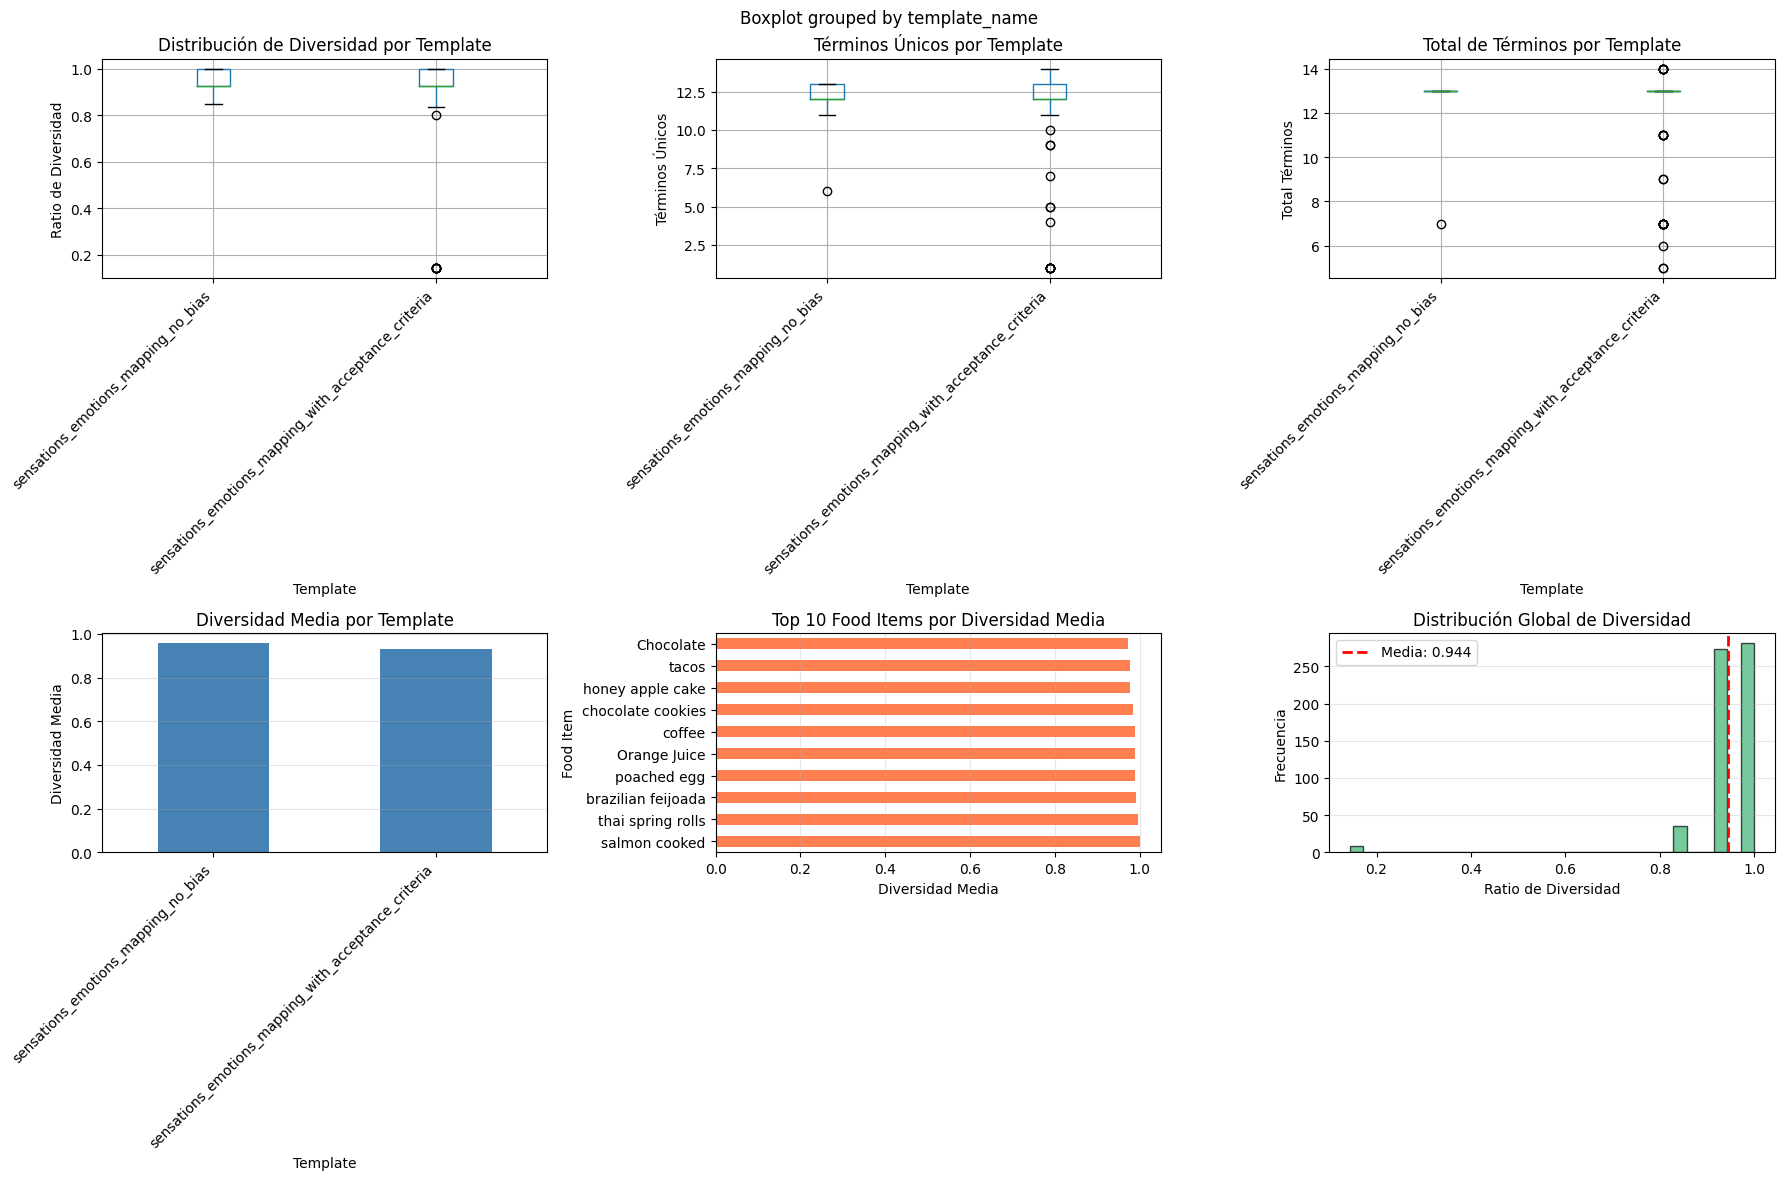

✅ Visualizaciones generadas exitosamente


In [14]:
# Crear visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Diversidad Léxica', fontsize=16, fontweight='bold')

# 1. Boxplot de diversidad por template
ax1 = axes[0, 0]
results_with_stats.boxplot(column='diversity_ratio', by='template_name', ax=ax1)
ax1.set_title('Distribución de Diversidad por Template')
ax1.set_xlabel('Template')
ax1.set_ylabel('Ratio de Diversidad')
plt.sca(ax1)
plt.xticks(rotation=45, ha='right')

# 2. Boxplot de términos únicos por template
ax2 = axes[0, 1]
results_with_stats.boxplot(column='unique_terms', by='template_name', ax=ax2)
ax2.set_title('Términos Únicos por Template')
ax2.set_xlabel('Template')
ax2.set_ylabel('Términos Únicos')
plt.sca(ax2)
plt.xticks(rotation=45, ha='right')

# 3. Boxplot de total términos por template
ax3 = axes[0, 2]
results_with_stats.boxplot(column='total_terms', by='template_name', ax=ax3)
ax3.set_title('Total de Términos por Template')
ax3.set_xlabel('Template')
ax3.set_ylabel('Total Términos')
plt.sca(ax3)
plt.xticks(rotation=45, ha='right')

# 4. Gráfico de barras: diversidad media por template
ax4 = axes[1, 0]
template_diversity = stats_by_template[('diversity_ratio', 'mean')].sort_values(ascending=False)
template_diversity.plot(kind='bar', ax=ax4, color='steelblue')
ax4.set_title('Diversidad Media por Template')
ax4.set_xlabel('Template')
ax4.set_ylabel('Diversidad Media')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# 5. Top 10 food items por diversidad
ax5 = axes[1, 1]
top_foods = stats_by_food_sorted[('diversity_ratio', 'mean')].head(10)
top_foods.plot(kind='barh', ax=ax5, color='coral')
ax5.set_title('Top 10 Food Items por Diversidad Media')
ax5.set_xlabel('Diversidad Media')
ax5.set_ylabel('Food Item')
ax5.grid(axis='x', alpha=0.3)

# 6. Histograma de distribución de diversidad
ax6 = axes[1, 2]
ax6.hist(results_with_stats['diversity_ratio'], bins=30, color='mediumseagreen', edgecolor='black', alpha=0.7)
ax6.set_title('Distribución Global de Diversidad')
ax6.set_xlabel('Ratio de Diversidad')
ax6.set_ylabel('Frecuencia')
ax6.axvline(global_stats.loc['mean', 'diversity_ratio'], color='red', linestyle='--', 
           linewidth=2, label=f"Media: {global_stats.loc['mean', 'diversity_ratio']:.3f}")
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizaciones generadas exitosamente")